In [50]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [51]:
import matplotlib.pyplot as plt

In [52]:
from timeit import default_timer as timer
from tqdm import tqdm
from os import cpu_count

In [53]:
!pip install -q torchmetrics
!pip install -U -q mlxtend
!pip install -q torchinfo

In [54]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchinfo import summary

## Setting the Device Agnostic Code

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Creating the Dataset Transformations

In [56]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

## Loading the Dataset

In [57]:
train_ds = CIFAR10(root="/content/", download=True, transform=train_transform, train=True)
test_ds = CIFAR10(root="/content/", download=True, transform=test_transform, train=False)
classes_names = test_ds.classes

print(len(train_ds), len(test_ds))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


## Plotting Some Images

In [58]:
def plot_single_image(img, label):
    plt.figure(figsize=(6, 3))
    plt.imshow(img.permute(1, 2, 0).cpu())
    plt.title(classes_names[label])
    plt.axis(False);

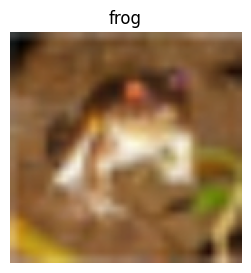

In [59]:
plot_single_image(*train_ds[0])

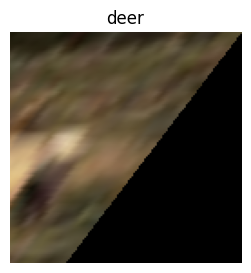

In [60]:
plot_single_image(*train_ds[3])

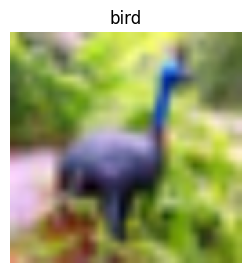

In [61]:
plot_single_image(*train_ds[6])

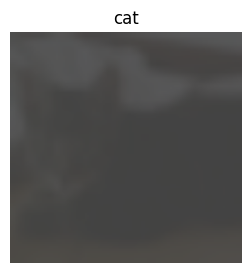

In [62]:
plot_single_image(*train_ds[9])

## Creating Device Loaders

In [63]:
class DeviceLoader:
    def __init__(self, dataset, device, batch_size=64, shuffle=True):
        self.loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=cpu_count(),
            pin_memory=True
        )
        self.device = device
        self.batch_size = batch_size

    def __to_device(self, data):
        if isinstance(data, (list, tuple)):
            return [self.__to_device(x) for x in data]
        return data.to(self.device, non_blocking=True)

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in self.loader:
            yield self.__to_device(batch)

In [64]:
# Initializing the Device Loaders
train_dl = DeviceLoader(train_ds, device, batch_size=32, shuffle=True)
test_dl = DeviceLoader(test_ds, device, batch_size=32, shuffle=False)

print(len(train_dl), len(test_dl))

1563 313


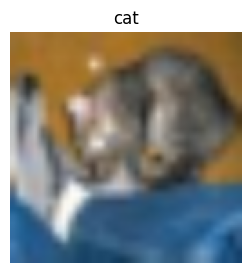

In [65]:
first_image_b, first_label_b = next(iter(test_dl))
plot_single_image(first_image_b[0], first_label_b[0])

## Creating the Accuracy Metric

In [69]:
def accuracy_fn(model_logits, labels):
    preds = torch.softmax(model_logits, dim=1).argmax(dim=1)

    return (preds == labels).sum().item() / len(labels)

## Creating the Models

1. ResNet
2. Transformer

### Creating the ResNet Model

In [ ]:
class ModelBase(nn.Module):
    def training_step(self, train_dl, opt):
        batch_size = train_dl.batch_size
        model_device = next(self.parameters()).device
        train_loss, train_eval = 0, 0

        print("\tTraining Step: ", end="")

        self.train()
        for x_train, y_train in tqdm(train_dl):
            model_logits = self(x_train)

            loss = self.loss_fn(model_logits, y_train)
            train_loss += loss.item()
            train_eval += self.eval_fn(model_logits, y_train)

            opt.zero_grad()
            loss.backward()
            opt.step()

        train_loss /= len(train_dl)
        train_eval /= len(train_dl)

        return train_loss, train_eval

    
    def validation_step(self, valid_dl):
        batch_size = valid_dl.batch_size
        model_device = next(self.parameters()).device
        valid_loss, valid_eval = 0, 0

        print("\tValidation Step: ", end="")

        self.eval()
        with torch.inference_mode():
            for x_valid, y_valid in tqdm(valid_dl):
                model_logits = self(x_valid)

                valid_loss += self.loss_fn(model_logits, y_valid).item()
                valid_eval += self.eval_fn(model_logits, y_valid)

            valid_loss /= len(valid_dl)
            valid_eval /= len(valid_dl)

            return valid_loss, valid_eval

    
    def fit(self, epochs, train_dl, valid_dl, opt):
        start_time = timer()
        train_losses, train_evals = [], []
        valid_losses, valid_evals = [], []

        print("Starting Process...\n")
        
        for epoch in range(1, epochs + 1):
            print(f"-> Epoch: {epoch}/{epochs}")

            train_loss, train_eval = self.training_step(train_dl, opt)
            valid_loss, valid_eval = self.validation_step(valid_dl)

            print()
            print(
                f"   Train Loss: {train_loss:.4f} | "
                f"Train Accuracy: {train_eval:.2f}% | "
                f"Valid Loss: {valid_loss:.4f} | "
                f"Valid Accuracy (%): {valid_eval:.2f}%")
            print("-" * 99, end="\n\n")
            
            train_losses.append(train_loss)
            train_evals.append(train_eval)
            valid_losses.append(valid_loss)
            valid_evals.append(valid_eval)

        print("Process Completed Successfully...")

        return {"model_train_loss": train_losses,
            "model_train_eval": train_evals,
            "model_valid_loss": valid_losses,
            "model_valid_eval": valid_evals,
            "model_name": self.__class__.__name__,
            "model_loss_fn": self.loss_fn.__class__.__name__,
            "model_evaluating_m": self.eval_fn.__name__,
            "model_optimizer": self.opt.__class__.__name__,
            "model_device": next(self.parameters()).device.type,
            "model_epochs": epochs,
            "model_time": timer() - start_time}

In [70]:
class ResNetModel(ModelBase):
    def __init__(self, input_channels, h1_units, h2_units, h3_units, h4_units, output_size, loss_fn, eval_fn):
        super().__init__()

        self.input_channels = input_channels
        self.h1_units = h1_units
        self.h2_units = h2_units
        self.h3_units = h3_units
        self.h4_units = h4_units
        self.output_size = output_size

        self.loss_fn = loss_fn
        self.eval_fn = eval_fn

        self.conv_block_1a = self.__conv_block(input_channels, h1_units, pool=False)
        self.conv_block_1b = self.__conv_block(h1_units, h1_units, pool=False)
        self.conv_block_1c = self.__conv_block(h1_units, h1_units, pool=True)

        self.conv_block_2a = self.__conv_block(h1_units, h2_units, pool=False)
        self.conv_block_2b = self.__conv_block(h2_units, h2_units, pool=False)
        self.conv_block_2c = self.__conv_block(h2_units, h2_units, pool=True)
        
        self.conv_block_3a = self.__conv_block(h2_units, h3_units, pool=False)
        self.conv_block_3b = self.__conv_block(h3_units, h3_units, pool=False)
        self.conv_block_3c = self.__conv_block(h3_units, h3_units, pool=True)
        
        self.conv_block_4a = self.__conv_block(h3_units, h4_units, pool=False)
        self.conv_block_4b = self.__conv_block(h4_units, h4_units, pool=False)
        self.conv_block_4c = self.__conv_block(h4_units, h4_units, pool=True)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=h4_units*8*8, out_features=output_size)
        )


    def forward(self, x):
        x = self.conv_block_1a(x) + self.__projection_layer(x, self.input_channels, self.h1_units)
        x = self.conv_block_1b(x) + x
        x = self.conv_block_1c(x) + self.__projection_layer(x, 128, 64, from_pool=True)

        x = self.conv_block_2a(x) + self.__projection_layer(x, self.h1_units, self.h2_units)
        x = self.conv_block_2b(x) + x
        x = self.conv_block_2c(x) + self.__projection_layer(x, 64, 32, from_pool=True)

        x = self.conv_block_3a(x) + self.__projection_layer(x, self.h2_units, self.h3_units)
        x = self.conv_block_3b(x) + x
        x = self.conv_block_3c(x) + self.__projection_layer(x, 32, 16, from_pool=True)

        x = self.conv_block_4a(x) + self.__projection_layer(x, self.h3_units, self.h4_units)
        x = self.conv_block_4b(x) + x
        x = self.conv_block_4c(x) + self.__projection_layer(x, 16, 8, from_pool=True)

        return self.classifier(x)

    
    def __projection_layer(self, x, input_dim, desire_dim, from_pool=False):
        if from_pool:
            x = nn.Linear(in_features=input_dim, out_features=desire_dim).to(device)(x)
            return nn.Linear(in_features=input_dim, out_features=desire_dim).to(device)(x.permute(0, 1, 3, 2)).permute(0, 1, 3, 2)

        return nn.Linear(in_features=input_dim, out_features=desire_dim).to(device)(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

    def __conv_block(self, input_c, output_c, pool=False):
        if pool:
            return nn.Sequential(
                nn.Conv2d(in_channels=input_c,
                        out_channels=output_c,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=output_c,
                        out_channels=output_c,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=output_c,
                        out_channels=output_c,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=1),
                nn.MaxPool2d(kernel_size=(2, 2))
            )

        return nn.Sequential(
            nn.Conv2d(in_channels=input_c,
                      out_channels=output_c,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_c,
                      out_channels=output_c,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_c,
                      out_channels=output_c,
                      kernel_size=(3, 3),
                      stride=1,
                      padding=1)
        )


In [71]:
# Initializing the Model
resNet = ResNetModel(input_channels=3,
                     h1_units=64,
                     h2_units=128,
                     h3_units=256,
                     h4_units=512,
                     output_size=10,
                     loss_fn=nn.CrossEntropyLoss(),
                     eval_fn=accuracy_fn).to(device)

summary(model=resNet,
        input_size=(32, 3, 128, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNetModel                              [32, 3, 128, 128]         [32, 10]                  --                        True
├─Sequential: 1-1                        [32, 3, 128, 128]         [32, 64, 128, 128]        --                        True
│    └─Conv2d: 2-1                       [32, 3, 128, 128]         [32, 64, 128, 128]        1,792                     True
│    └─ReLU: 2-2                         [32, 64, 128, 128]        [32, 64, 128, 128]        --                        --
│    └─Conv2d: 2-3                       [32, 64, 128, 128]        [32, 64, 128, 128]        36,928                    True
│    └─ReLU: 2-4                         [32, 64, 128, 128]        [32, 64, 128, 128]        --                        --
│    └─Conv2d: 2-5                       [32, 64, 128, 128]        [32, 64, 128, 128]        36,928                    True
├─Seque

### Setting Optimizer

In [72]:
opt = optim.Adam(params=resNet.parameters(), lr=1e-4)

### Training and Evaluating the Model

In [73]:
res_1 = resNet.fit(model=resNet,
                   epochs=10,
                   train_dl=train_dl,
                   valid_dl=test_dl,
                   opt=opt)

Starting Process...

-> Epoch: 1/10
	Training Step: 

100%|██████████| 1563/1563 [15:35<00:00,  1.67it/s]


	Validation Step: 

100%|██████████| 313/313 [01:06<00:00,  4.70it/s]



   Train Loss: 2.3966 | Train Accuracy: 0.10% | Valid Loss: 2.3812 | Valid Accuracy (%): 0.10%
---------------------------------------------------------------------------------------------------

-> Epoch: 2/10
	Training Step: 

100%|██████████| 1563/1563 [15:30<00:00,  1.68it/s]


	Validation Step: 

100%|██████████| 313/313 [01:05<00:00,  4.79it/s]



   Train Loss: 2.3999 | Train Accuracy: 0.10% | Valid Loss: 2.3922 | Valid Accuracy (%): 0.10%
---------------------------------------------------------------------------------------------------

-> Epoch: 3/10
	Training Step: 

  1%|          | 8/1563 [00:05<16:58,  1.53it/s]


KeyboardInterrupt: ignored